# Lentes múltiples

En esta sección trataremos las lentes múltiples para dar una visión más general del fenomenos de las lentes gravitatorias.

El notebook se basa en los códigos disponibles en el GitHub (https://github.com/maxmen/LensingLectures) creado por Massimo Meneghetti.

## Deflexión

La ecuación de la deflexión del ángulo que hemos obtenido en la aproximación de lente fina ha sido

$$
\hat\alpha_{GR} \approx \frac{4 G M}{c^2 \xi^2} \vec{\xi}.
$$

Esta ecuación nos permite ver que la dependencia de la masa es lineal. Gracias a eso podemos utilizar el principio de superposición para sumar la desviación que genera cada lente y encontrar la deflexión total que genera una serie de lentes:

\begin{equation}
    \hat{\vec\alpha}(\xi)=\frac{4G}{c^2}\sum_i \frac{M_i}{|\vec\xi_i-\vec\xi|^2}(\vec\xi_i-\vec\xi)
\end{equation}

En el ejemplo concreto que ponemos a continuación Massimo Meneghetti utiliza una distribución aleatoria de lentes y calcula la deflexión que generan en el centro de la imagen.

Adicionalmente, se asume que todas las masas pesan lo mismo y la longitu del vector se reescala para que siempre valga 0.1.

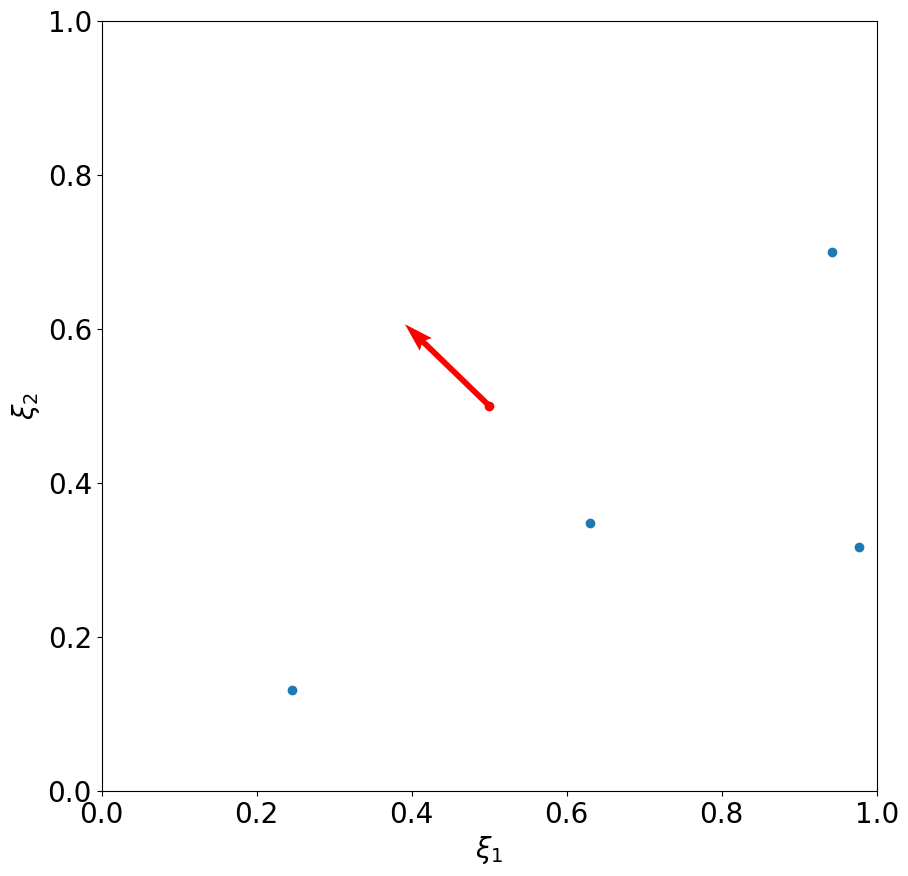

In [34]:
# generate a random distribution of point masses
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rn
from astropy import constants as const
from astropy import units as u


# number of point lenses: you can play with this number!
n=4


#################
# distribute lenses at random positions in a region of 1pc x 1pc
xi_1=rn.rand(n)*u.pc
xi_2=rn.rand(n)*u.pc

# assign to all lenses the same mass (1 Msun)
m=np.ones(n)*const.M_sun.to('kg')

# now set the ray position at (0.5pc,0.5pc)
xi_1r=0.5*u.pc
xi_2r=0.5*u.pc

# compute distances from xr,yr
xi1=(xi_1r-xi_1).to('m')
xi2=(xi_2r-xi_2).to('m')

#print ((4.0*const.G/const.c**2*m/const.R_sun)*u.rad.to('arcsec'))#180.0/np.pi*3600.0)

rl2=(xi1**2+xi2**2).to('m2')

al1=(4.0*const.G/const.c**2*m/rl2*xi1).sum().value
al2=(4.0*const.G/const.c**2*m/rl2*xi2).sum().value
f=1e10#1e-2/np.sqrt(al1**2+al2**2)

fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.plot(xi_1,xi_2,'o',zorder=-1)
ax.plot(xi_1r,xi_2r,'o',color='red')
ax.quiver(xi_1r.value, xi_2r.value, al1*f, al2*f, color='r', scale=0.1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'$\xi_1$',fontsize=20)
ax.set_ylabel(r'$\xi_2$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


El código de abajo es el único código propio de este cuaderno.

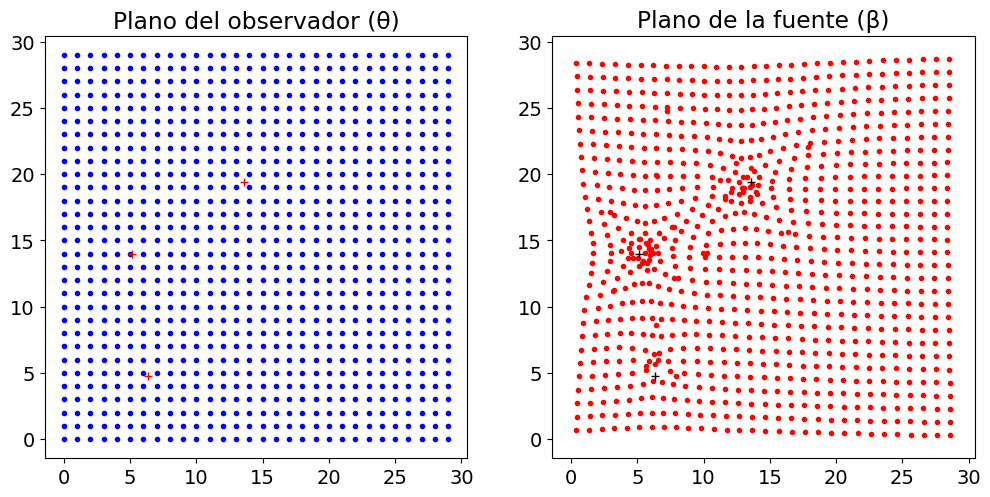

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rn
from astropy.constants import G, M_sun, c

G_val=1
c_val=1
M_val=1

# Número de píxeles en cada eje x/y
npix = 30

# Generamos una malla en unidades de \xi
x1 = np.linspace(0.0, 1.0, npix) * (npix - 1)  #\vec x= (\vec \xi) / \xi_0
x2 = np.linspace(0.0, 1.0, npix) * (npix - 1)  
x1, x2 = np.meshgrid(x1, x2)

# Posiciones de los objetos lentificadores
n = 3  # número de lentes
x0_1 = []
x0_2 = []
m = []

if n==1:
    x0_1=[(npix-1)//2]
    x0_2=[(npix-1)//2]
    m=[2 * 1.e13]
else:
    for k in range(n):
        x0_1.append(rn.random() * (npix - 1))
        x0_2.append(rn.random() * (npix - 1))
        m.append(2 * rn.random() * 1.e13)

# Deflexión del ángulo (en 2D)

alpha_x = np.zeros_like(x1)
alpha_y = np.zeros_like(x2)
eta_0 = 1.e14

for i in range(n):
    dx = x1 - x0_1[i]
    dy = x2 - x0_2[i]
    r2 = (dx**2 + dy**2) * eta_0

    factor = 4.0 * G_val / c_val**2 * m[i]
    alpha_x +=  4.0 * G_val / c_val**2 * m[i] * dx / r2 
    alpha_y +=  4.0 * G_val / c_val**2 * m[i] * dy / r2

# Ecuación de la lente (y = x - D_{ls}*D_L/D_{s} /eta_0 α)

D_ls = 20 * 1e14
D_s  = 40 * 1e14
d_L  = 20 * 1e14 # distancia a la lente en metros

y1 = x1 - (D_ls * d_L / D_s / eta_0) * alpha_x 
y2 = x2 - (D_ls * d_L / D_s / eta_0) * alpha_y  #factor 1/1000 por D_{ls}/D_{s}

# Plot de los resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Límites para los gráficos
buffer = 1.05
y1_max = np.max(y1) * buffer
y1_min = np.min(y1) / buffer
y2_max = np.max(y2) * buffer
y2_min = np.min(y2) / buffer

x_max=(npix - 1) *1.05
# malla original
ax1.set_xlim(-0.05*(npix-1), x_max)
ax1.set_ylim(-0.05*(npix-1), x_max)
ax1.set_aspect('equal')
ax1.plot(x1.flatten(), x2.flatten(), '.', color='blue', label='Píxeles observados')
ax1.plot(x0_1, x0_2, '+', color='red', label='Lentes')
ax1.set_title('Plano del observador (θ)')
#ax1.legend()

# malla desplazada
ax2.set_xlim(-0.05*(npix-1), x_max)
ax2.set_ylim(-0.05*(npix-1), x_max)
ax2.set_aspect('equal')
ax2.plot(y1.flatten(), y2.flatten(), '.', color='red', label='Posiciones aparentes')
ax2.plot(x0_1, x0_2, '+', color='black', label='Lentes')
ax2.set_title('Plano de la fuente (β)')
#ax2.legend()

#plt.tight_layout()
plt.savefig(f"../../Multimedia/Massimo_Meneghetti/Ray-tracing básico con n={n} lentes.png")

## Deflexión por una distribución de masa

En este caso nos basámos en el [Notebook 7a](https://github.com/maxmen/LensingLectures/blob/master/Notebooks/.ipynb_checkpoints/5_2019-checkpoint.ipynb) de Massimo Meneghetti, donde implementa el cálculo del campo del ángulo de deflexión producido por una lente extendida. Un mapa bidimensional de la densidad superficial de la lente se encuentra en la carpeta \texttt{data} y se llama \texttt{kappa_2.fits}.

Este archivo contiene la densidad superficial dividida por una constante que depende del corrimiento al rojo de la lente y de la fuente. Denotamos esta cantidad como $\kappa$. Teniendo en cuenta esta normalización, el cálculo que queremos implementar es:

\begin{equation}
\vec{\alpha}(\vec{x}) = \frac{1}{\pi} \int \kappa(\vec{x}') \frac{\vec{x} - \vec{x}'}{|\vec{x} - \vec{x}'|^2} \, d^2x' \;.
\end{equation}

Esta expresión representa una convolución, la cual puede escribirse en el espacio de Fourier como:

\begin{equation}
\vec{\tilde{\alpha}}(\vec{k}) = \frac{1}{\pi} \, \tilde{\kappa}(\vec{k}) \, \vec{\tilde{K}}(\vec{k}),
\end{equation}

donde $\vec{\tilde{K}}(\vec{k})$ es la transformada de Fourier de

\begin{equation}
\vec{K}(\vec{x}) = \frac{\vec{x}}{|\vec{x}|^2}.
\end{equation}

Para implementar este cálculo, utilizamos el módulo \texttt{numpy.fft}. Con objetivo de implementar la Transformada Discreta de Fourier (DFT por sus sigles en inglés) mediante el método de la Transformada Rápida de Fourier (FFT por sus siglas en ingés).

\begin{equation}
    \tilde{\kappa}_{kl}= \sum^{n_{pix}-1}_{m=0} \, \sum_{n=0}^{n_{pix}-1} \kappa_{mn} \exp \left[- 2 \pi i  \left(\frac{km}{n_{pix}}+ \frac{ln}{n_{pix}}\right)\right].
\end{equation}

In [48]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as pyfits
from astropy.convolution import convolve_fft

class deflector(object):
    
    # initialize the deflector using a surface density (covergence) map
    # the boolean variable pad indicates whether zero-padding is used or not
    def __init__(self,filekappa,pad=False):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.pixel=header['CDELT2']*3600.0
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        self.kx,self.ky=self.kernel()
        
    # implement the kernel function K
    def kernel(self):
        x=np.linspace(-self.kappa.shape[0]/2.,self.kappa.shape[0]/2.,self.kappa.shape[0])
        y=np.linspace(-self.kappa.shape[1]/2.,self.kappa.shape[1]/2.,self.kappa.shape[1])
        kx,ky=np.meshgrid(x,y)
        norm=(kx**2+ky**2+1e-12)
        kx=kx/norm
        ky=ky/norm
        return(kx,ky)
    
    # compute the deflection angle maps by convolving
    # the surface density with the kernel function
    def angles(self):
        # FFT of the surface density and of the two components of the kernel
        kappa_ft = fft.rfftn(self.kappa,axes=(0,1))
        kernelx_ft = fft.rfftn(self.kx,axes=(0,1),
                                     s=self.kappa.shape)
        kernely_ft = fft.rfftn(self.ky,axes=(0,1),
                                     s=self.kappa.shape)
        # perform the convolution in Fourier space and transform the result
        # back in real space. Note that a shift needs to be applied using 
        # fftshift
        #alphax = 1.0/np.pi/(self.kappa.shape[0])*\
        #        fft.fftshift(fft.irfftn(kappa_ft*kernelx_ft))
        #alphay = 1.0/np.pi/(self.kappa.shape[0])*\
        #        fft.fftshift(fft.irfftn(kappa_ft*kernely_ft))
        alphax = 1.0/np.pi*\
                fft.fftshift(fft.irfftn(kappa_ft*kernelx_ft))
        alphay = 1.0/np.pi*\
                fft.fftshift(fft.irfftn(kappa_ft*kernely_ft))
        print (np.min(alphax),np.max(alphax))
        return(alphax,alphay)
    
    # alternative: use method convolve_fft from astropy.convolution
    def angles2(self):
        kx,ky=self.kernel()
        alphax=convolve_fft(self.kappa,kx,normalize_kernel=False,nan_treatment='fill',fft_pad=False,boundary='wrap')
        alphay=convolve_fft(self.kappa,ky,normalize_kernel=False,nan_treatment='fill',fft_pad=False,boundary='wrap')
        alphax*=1.0/np.pi
        alphay*=1.0/np.pi
        print (np.min(alphax),np.max(alphax))
        return(alphax,alphay)
    
    # returns the surface-density (convergence) of the deflector
    def kmap(self):
        return(self.kappa)
    
    # performs zero-padding
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros) in a
        # frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
    
    # crop the maps to remove zero-padded areas and get back to the original 
    # region.
    def mapCrop(self,mappa):
        xmin=np.int(self.kappa.shape[0]/2-self.nx/2)
        ymin=np.int(self.kappa.shape[1]/2-self.ny/2)
        xmax=np.int(xmin+self.nx)
        ymax=np.int(ymin+self.ny)
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)

    def potential(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fft.fftfreq(self.kappa.shape[0])\
                                 ,fft.fftfreq(self.kappa.shape[1]))).astype('float64')
        #Compute Laplace operator in Fourier space = -4*pi*k^2
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fft.fftn(self.kappa)
        #compute the FT of the potential
        kappa_ft *= - 1.0 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fft.ifftn(kappa_ft)
        return potential.real
    
def convergence(a1,a2):
    a12,a11=np.gradient(a1)
    a22,a21=np.gradient(a2)
    kappa=0.5*(a11+a22)
    return(kappa)    

-207.4221276965698 228.76333487846483


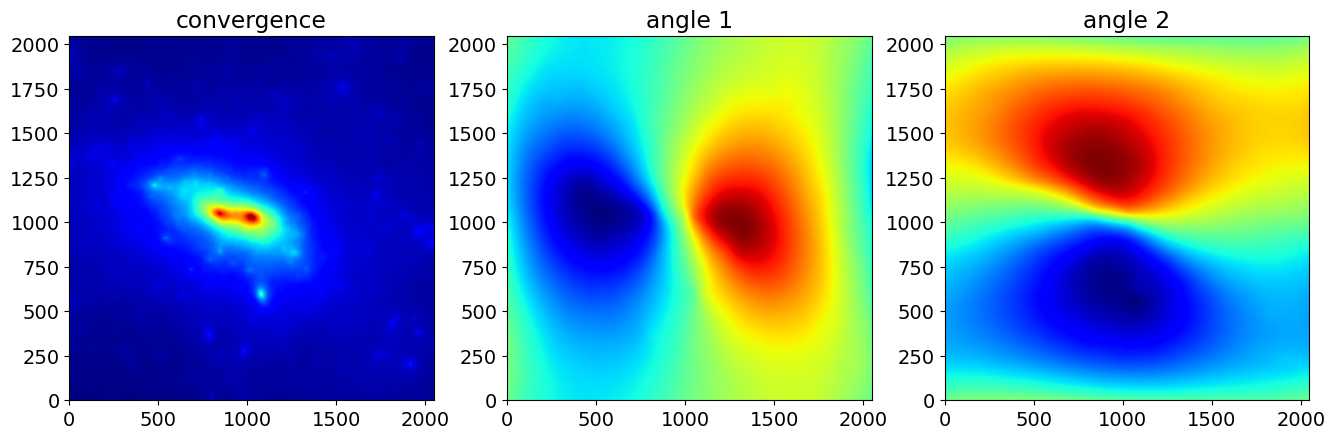

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet'
df=deflector('../../data/kappa_2.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

#plot the results
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower",vmax=2.5)
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('../../Multimedia/Massimo_Meneghetti/Deflexión_distrbución_de_masa.png')

Este resultado no es del todo correcto ya que la DFT asume condiciones de contorno periódicas. Esto induce errores en las esquinas de la imagen para el ángulo $\vec{\alpha}$, lo que se puede corregir con un método que se llama \textit{zero-padding}. Este método aumenta el tamaño da la imagen al añadir casillas que en este caso toman el valor $\kappa=0$ a su alrededor. Para reproducir unas condiciones periódicas más realistas.

In [54]:
df=deflector('../../data/kappa_2.fits', True)
angx,angy=df.angles()
kappa=df.kmap()
#plt.rcParams['image.cmap'] = 'jet'
fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower",vmax=2.5)
ax[0].set_title('convergence')
ax[1].imshow(angx,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('../../Multimedia/Massimo_Meneghetti/Deflexión_distrbución_de_masa/padding.png')

AttributeError: module 'numpy.lib' has no attribute 'pad'

## Ray tracing

Utilizaremos el método de ray-tracing que hemos utilizado anteriormente en las lentes indiciduales

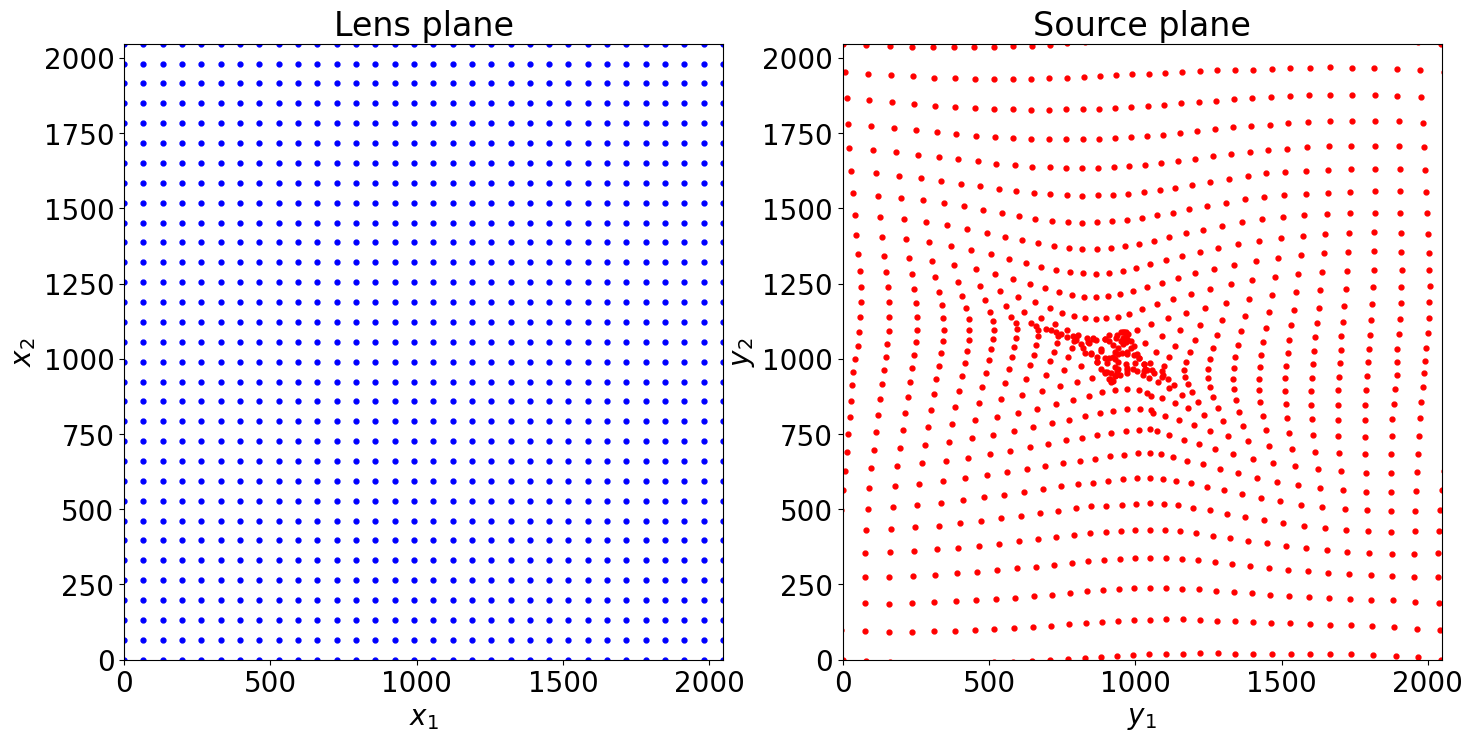

In [55]:
npix=angx.shape[0]
ndown=64
x1=np.linspace(0.0,1.0,int(npix/ndown))*(npix-1) # dowsampled x1,x2 coordinates
x2=np.linspace(0.0,1.0,int(npix/ndown))*(npix-1) # 
x1_,x2_=np.meshgrid(x1,x2) # downsampled grid
# now we need to interpolate the defl. angle maps at (x1_,x2_)
# we can use the method map_coordinates from scipy.ndimage
from scipy.ndimage import map_coordinates

# first, we need to reshape x1_ and x2_:
x=np.reshape(x1_,x1_.size)
y=np.reshape(x2_,x2_.size)
# then we interpolate:
angx_=map_coordinates(angx,[[y],[x]],order=5)
angy_=map_coordinates(angy,[[y],[x]],order=5)
# now we reshape the angles back to a mesh
angx_=angx_.reshape((int(npix/ndown),int(npix/ndown)))
angy_=angy_.reshape((int(npix/ndown),int(npix/ndown)))
# finally we ray-trace:
y1=x1_-angx_
y2=x2_-angy_
# or
#y1=(x1-angx_)
#y2=np.transpose(x2-np.transpose(angy_))

#plot the results
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)

fig,ax=plt.subplots(1,2,figsize=(17,8))
ax[0].plot(np.reshape(x1_,x2_.size),np.reshape(x2_,x2_.size),'o',color='blue',markersize=3.5)
ax[1].plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),'o',color='red',markersize=3.5)
ax[0].set_title('Lens plane')
ax[1].set_title('Source plane')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[1].set_xlabel('$y_1$')
ax[1].set_ylabel('$y_2$')
for i in [0,1]:
    ax[i].set_xlim([0,np.max(x1)])
    ax[i].set_ylim([0,np.max(x2)])

fig.savefig('../../Multimedia/Massimo_Meneghetti/Distribución_ray_tracing.png')

## Superficies de retardo temporal

Este notebook es una adaptación del notebook de Massimo Menegghetti que se puede encontrar en el siguiente GitHub: (https://github.com/maxmen/LensingLectures)

In [3]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 25}

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', **font)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import map_coordinates
import pylab
import astropy.io.fits as pyfits
from scipy.ndimage import map_coordinates
import numpy.fft as fftengine


# the parent class
class gen_lens(object):
    def __init__(self):
        self.pot_exists=False
    
    # geometrical time delay: proportional to (theta-beta)**2
    def t_geom_surf(self, beta=None):
        # this is a method to create a mesh of coordinates (x,y)
        # note that x,y vary between 0 and npix*pixel
        x = np.arange(0, self.npix, 1, float)*self.pixel
        y = x[:,np.newaxis]
        # if there is a source at beta, compute its coordinates (x0,y0)
        # it no source position is provided, set the position at the center of the grid
        if beta is None:
            x0 = y0 = self.npix / 2*self.pixel
        else:
            x0 = beta[0]+self.npix/2*self.pixel
            y0 = beta[1]+self.npix/2*self.pixel
        # now we can compute the geometrical time delay surface:
        return 0.5*((x-x0)*(x-x0)+(y-y0)*(y-y0))
    
    # gravitational time delay: this is just the lensing potential (times -1)
    def t_grav_surf(self):
        return -self.pot
    
    # total time delay: computed by summing the geometrical and the gravitational time delays
    def t_delay_surf(self,beta=None):
        t_grav=self.t_grav_surf()
        t_geom=self.t_geom_surf(beta)
        td=(t_grav+t_geom)
        return(t_grav+t_geom)
    
    # convergence: computed from the laplacian of the lensing potential 
    def convergence(self):
        if (self.pot_exists):
            kappa=0.5*(self.a11+self.a22)
        else:
            print ("The lens potential is not initialized yet")
            
        return(kappa)
    
    #shear: computed from other combinantions of the lensing potential
    def shear(self):
        if (self.pot_exists):
            g1=0.5*(self.a11-self.a22)
            g2=self.a12
        else:
            print ("The lens potential is not initialized yet")
        return(g1,g2)
    
    # determinant of the Jacobian matrix
    def detA(self):
        if (self.pot_exists):
            deta=(1.0-self.a11)*(1.0-self.a22)-self.a12*self.a21
        else:
            print ("The lens potential is not initialized yet")
        return(deta)
    
    # critical lines overlaid to the map of detA, returns a set of contour objects
    def crit_lines(self,ax=None,show=True):
        if (ax==None): 
            print ("specify the axes to display the critical lines")
        else:
            deta=self.detA()
            #ax.imshow(deta,origin='lower')
            cs=ax.contour(deta,levels=[0.0],colors='white',alpha=0.0)
            if show==False:
                ax.clear()
        return(cs)
    
    # plot of the critical lines
    def clines(self,ax=None,color='red',alpha=1.0,lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=False)
        contour=cs.collections[0]
        p=contour.get_paths()
        sizevs=np.empty(len(p),dtype=int)
        
        no=self.pixel
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                #the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
        
                # plot the results!
                ax.plot((np.array(x1)-self.npix/2.)*no,
                        (np.array(x2)-self.npix/2.)*no,lt,color=color,alpha=alpha)
        ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
        ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
    
    # plot of the caustics
    def caustics(self,ax=None,alpha=1.0,color='red',lt='-',fontsize=15):
        cs=self.crit_lines(ax=ax,show=True)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual 
                              # critical line
        sizevs=np.empty(len(p),dtype=int)
        
        # if we found any contour, then we proceed
        if (sizevs.size > 0):
            for j in range(len(p)):
                # for each path, we create two vectors containing 
                # the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)
                x1=[]
                x2=[]
                for i in range(len(vs)):
                    xx1,xx2=vs[i]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                # these are the points we want to map back on the source plane. 
                # To do that we need to evaluate the deflection angle at their positions
                # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
                a_1=map_coordinates(self.a1, [[x2],[x1]],order=1)
                a_2=map_coordinates(self.a2, [[x2],[x1]],order=1)
        
                # now we can make the mapping using the lens equation:
                no=self.pixel
                y1=(x1-a_1[0]-self.npix/2.)*no
                y2=(x2-a_2[0]-self.npix/2.)*no
        
                # plot the results!
                #ax.plot((np.array(x1)-npix/2.)*no*f,(np.array(x2)-npix/2.)*no*f,'-')
                ax.plot(y1,y2,lt,color=color,alpha=alpha)
            ax.set_xlabel(r'$\beta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\beta_2$',fontsize=fontsize)
                
    # display the time delay surface
    def show_surface(self,surf0,ax=None,minx=-25,miny=-25,vmax=2,rstride=1,
                     cstride=1,cmap=plt.get_cmap('Paired'),
                     linewidth=0, antialiased=False,alpha=0.2,fontsize=20,offz=0.0):
        
        surf=surf0+offz
        if ax==None:
            print ("specify the axes with 3d projection to display the surface")
        else:
            xa=np.arange(-self.npix/2, self.npix/2, 1)
            ya=np.arange(-self.npix/2, self.npix/2, 1)
        # I will show the contours levels projected in the x-y plane
            levels=np.linspace(np.amin(surf),np.amax(surf),40)

            minx=minx
            maxx=-minx

            miny=miny
            maxy=-miny

            pixel_size=self.size/(self.npix-1)
            X, Y = np.meshgrid(xa*pixel_size, ya*pixel_size)
            ax.plot_surface(X,Y,surf,vmax=vmax,rstride=rstride, cstride=cstride, cmap=cmap,
                       linewidth=linewidth, antialiased=antialiased,alpha=alpha)

            cset = ax.contour(X, Y, surf, zdir='z', 
                               offset=np.amin(surf)-20.0, cmap=cmap,levels=levels)
            deta=self.detA()
            cset = ax.contour(X, Y, deta, zdir='z', 
                               offset=np.amin(surf)-20.0, colors='black',levels=[0])            
            cset = ax.contour(X, Y, surf, zdir='x', offset=minx, cmap=cmap,levels=[0])
            cset = ax.contour(X, Y, surf, zdir='y', offset=maxy, cmap=cmap,levels=[0])
            ax.set_xlim3d(minx, maxx)
            ax.set_ylim3d(miny, maxy)
            ax.set_zlim3d(np.amin(surf)-20.0, 10)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('auto')            

    # display the time delay contours
    def show_contours(self,surf0,ax=None,minx=-25,miny=-25,cmap=plt.get_cmap('Paired'),
                     linewidth=1,fontsize=20,nlevels=40,levmax=100,offz=0.0):
        if ax==None:
            print ("specify the axes to display the contours")
        else:
            minx=minx
            maxx=-minx
            miny=miny
            maxy=-miny
            surf=surf0-np.min(surf0)
            levels=np.linspace(np.min(surf),levmax,nlevels)
            ax.contour(surf, cmap=cmap,levels=levels,
                       linewidth=linewidth,
                       extent=[-self.size/2,self.size/2,-self.size/2,self.size/2])
            ax.set_xlim(minx, maxx)
            ax.set_ylim(miny, maxy)
            ax.set_xlabel(r'$\theta_1$',fontsize=fontsize)
            ax.set_ylabel(r'$\theta_2$',fontsize=fontsize)
            ax.set_aspect('equal')    

# child class PSIE
class psie(gen_lens):
    def __init__(self,size=100.0,npix=200,**kwargs):
        
        if ('theta_c' in kwargs):
            self.theta_c=kwargs['theta_c']
        else:
            self.theta_c=0.0
            
        if ('ell' in kwargs):
            self.ell=kwargs['ell']
        else:
            self.ell=0.0
            
        if ('norm' in kwargs):
            self.norm=kwargs['norm']
        else: 
            self.norm=1.0
            
        self.size=size
        self.npix=npix
        self.pixel=float(self.size)/float((self.npix-1))
        self.potential()
        
    # lensing potential for the PSIE model
    def potential(self):
        x = np.arange(0, self.npix, 1, float)
        y = x[:,np.newaxis]
        x0 = y0 = self.npix / 2
        no=self.pixel**2
        self.pot_exists=True
        pot=np.sqrt(((x-x0)*self.pixel)**2/(1-self.ell)
                         +((y-y0)*self.pixel)**2*(1-self.ell)
                         +self.theta_c**2)*self.norm
        self.pot=pot
        # deflection angles are obtained by taking the gradient of psi
        self.a2,self.a1=np.gradient(self.pot/self.pixel**2)
        
        # taking the gradient of the two components of the potential is equivalent to 
        # taking the second derivatives of the potential, which will be used to compute 
        # convergence, shear and then det A, critical lines and caustics
        self.a12,self.a11=np.gradient(self.a1)
        self.a22,self.a21=np.gradient(self.a2)

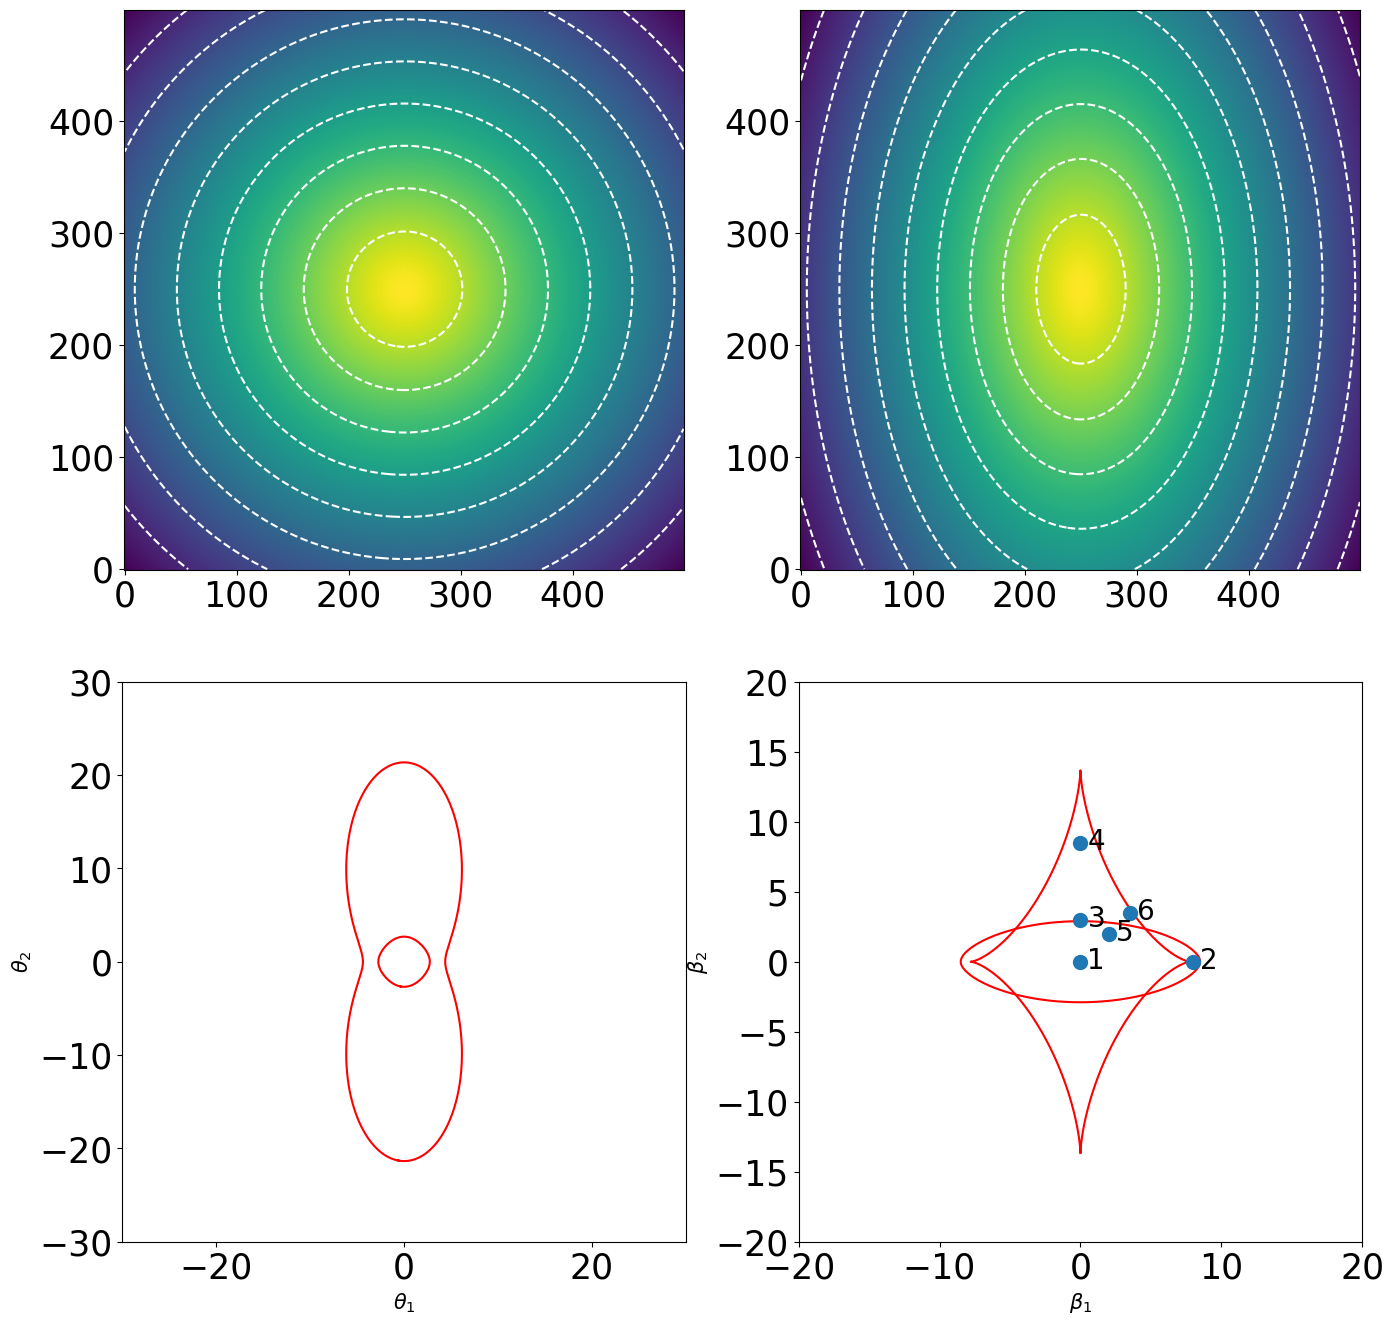

In [4]:

%matplotlib inline

# We create a map of 500x500 pixels, which is 60 (arcsec) wide on the side
size=60.
npix=500.

# Now we create a lens belonging to the class psie. The lens is defined by two parameters 
# the first is theta_c (the core radius) and the second is norm (which is a parameter which quantifies
# how big is the lens -- for example what is its mass)
# 
# The first lens (cl) we create has zero ellipticty:
kwargs={'theta_c': 2.0, 'norm': 10.0, 'ell': 0.0}
cl=psie(size=size,npix=npix,**kwargs)

# then we create a lens with ellipticity 0.4, and we call it el:
kwargs={'theta_c': 2.0, 'norm': 10.0, 'ell': 0.4}
el=psie(size=size,npix=npix,**kwargs)


# for both the lenses we can use the method t_grav_surf to compute the gravitational time delay surface,
# which is basically the minus the lensing potential:
t_grav_surf0=cl.t_grav_surf()
t_grav_surf=el.t_grav_surf()


# now we create a plot showing the time delay surfaces for the lenses cl and el. For clarity, we also display
# some contours that show that the maps of the potentials are truly circular and elliptical for the two lenses.
# These two maps will appear in a couple of panels in the upper part of the figure we are creating.

l0=np.linspace(t_grav_surf0.min(),t_grav_surf0.max(),10)

fig,ax=plt.subplots(2,2,figsize=(16,16)) # note that the figure is composed of 2x2 panels
ax[0,0].imshow(t_grav_surf0,origin='lower') # grav. time delay of lens cl in the upper left panel
ax[0,1].imshow(t_grav_surf,origin='lower')  # grav. time delay of lens el in the upper right panel
ax[0,0].contour(t_grav_surf0,levels=l0,colors='white')
ax[0,1].contour(t_grav_surf,levels=l0,colors='white')

# In the bottom panels, we are going to show the critical lines and the caustics of the lenses. As we know, 
# the caustics are lines on the source plane. For the following part of the exercise, we place 6 point sources
# at some specific positions near the caustics
el.clines(ax=ax[1,0])
el.caustics(ax=ax[1,1])
ax[1,0].set_xlim([-30,30])
ax[1,0].set_ylim([-30,30])
ax[1,1].set_xlim([-20,20])
ax[1,1].set_ylim([-20,20])

betax=[0,8,0,0,2,3.5]
betay=[0,0,3,8.5,2,3.5]
labels=['1','2','3','4','5','6']
ax[1,1].plot(betax,betay,'o',markersize=10)
for i, txt in enumerate(labels):
    ax[1,1].annotate(txt, (betax[i]+0.5,betay[i]-0.5),fontsize=20)

## Deflexión segundo orden




En este caso utilizamos en concreto el siguiente notebook de Massimo Meneghetti: (https://github.com/maxmen/LensingLectures/blob/master/Notebooks/5_2020_2order_distortions.ipynb)

Consideremos una pequeña región del plano de la lente alrededor de $\vec{\theta}_0 = (0,0)$. La ecuación de lente, incluyendo términos hasta segundo orden, se escribe como:

\begin{equation}
\beta_i = \frac{\partial \beta_i}{\partial \theta_j} \theta_j + \frac{1}{2} \frac{\partial \beta_i}{\partial \theta_j \partial \theta_k} \theta_j \theta_k
\end{equation}

Cada término en la ecuación representa una suma sobre los índices $(j,k) \in (1,2)$, aunque se omite el símbolo de sumatoria por conveniencia.

Dado que:

\begin{equation}
\frac{\partial \beta_i}{\partial \theta_j} = A_{ij},
\end{equation}

la ecuación puede reescribirse como:

\begin{equation}
\beta_i = A_{ij} \theta_j + \frac{1}{2} D_{ijk} \theta_j \theta_k,
\end{equation}

donde se ha introducido la matriz $D_{ijk}$.

Como ya hemos visto, los elementos de $D$, es decir, $D_{ijk}$, se expresan como derivadas terceras del potencial de lente. Estas, a su vez, pueden escribirse en términos de las flexiones $F$ y $G$. Después de algunos cálculos, obtenemos:

\begin{align}
D_{111} &= -2\gamma_{11} - \gamma_{22} = -\frac{1}{2}(3F_1 + G_1) \\
D_{211} &= D_{121} = D_{112} = -\gamma_{21} = -\frac{1}{2}(F_2 + G_2) \\
D_{122} &= D_{212} = D_{221} = -\gamma_{22} = -\frac{1}{2}(F_1 - G_1) \\
D_{222} &= 2\gamma_{12} - \gamma_{21} = -\frac{1}{2}(3F_2 - G_2)
\end{align}

Podemos ver fácilmente que las dos componentes de $\vec{\beta}$ son:

\begin{align}
\beta_1 &= A_{11}\theta_1 + A_{12}\theta_2 + \frac{1}{2}D_{111}\theta_1^2 + D_{121}\theta_1\theta_2 + \frac{1}{2}D_{122}\theta_2^2 \\
\beta_2 &= A_{21}\theta_1 + A_{22}\theta_2 + \frac{1}{2}D_{211}\theta_1^2 + D_{212}\theta_1\theta_2 + \frac{1}{2}D_{222}\theta_2^2
\end{align}

\section*{Perfil de brillo de la fuente}

Consideremos ahora una fuente circular centrada en $\vec{\beta}_0 = (0,0)$. A esta fuente le asignamos un perfil de brillo superficial. Para este ejercicio podemos utilizar un perfil general de Sérsic \cite{sersic1963} de la forma:

\begin{equation}
I_s(\beta) \propto \exp\left\{ -b_n \left[ \left(\frac{\beta}{r_e}\right)^{1/n} - 1 \right] \right\},
\end{equation}

donde:

\begin{equation}
b_n = 1.992n - 0.3271
\end{equation}

para $0.5 < n < 8$, $r_e$ es el \textit{radio efectivo} de la fuente y $n$ es el \textit{índice de Sérsic}.

\section*{Reconstrucción de la imagen}

Como el brillo superficial se conserva:

\begin{equation}
I(\vec{\theta}) = I_s(\vec{\beta} = \vec{\theta} - \vec{\alpha}(\vec{\theta})).
\end{equation}

Esto nos permite reconstruir directamente la imagen de la fuente en el plano de la lente. La ecuación de lente anterior nos permite mapear las coordenadas $\vec{\theta}$ a las coordenadas $\vec{\beta}$ en el plano de la fuente. Esto constituye un procedimiento de trazado de rayos (\textit{ray tracing}).

Podemos cubrir el plano de la lente con una malla de coordenadas $\vec{\theta}$ y, una vez que conocemos las coordenadas correspondientes $\vec{\beta}$, podemos obtener el valor del brillo superficial en $\vec{\theta}$ a partir del mapa de $I_s(\vec{\beta})$.

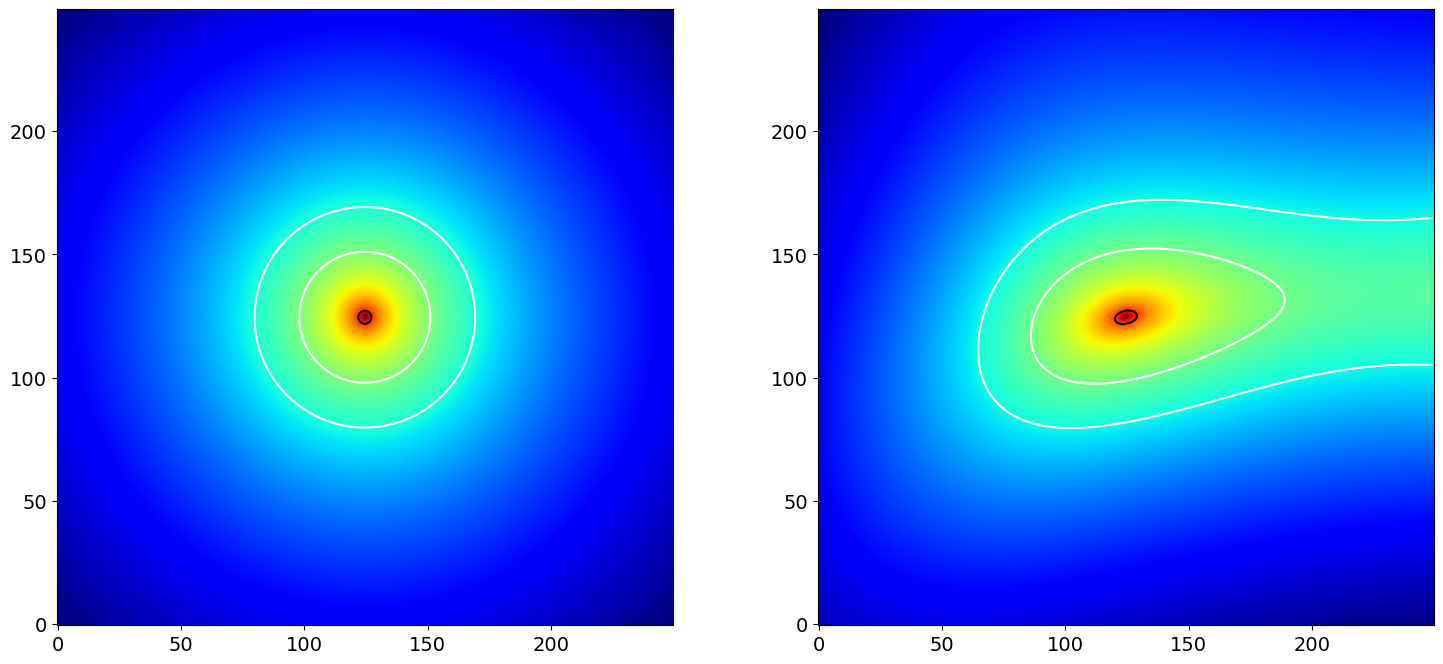

In [5]:
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

plt.rcParams['image.cmap'] = 'jet'

class sersic(object):
    
    def __init__(self,side,N,**kwargs):
        
        if ('n' in kwargs):
            self.n=kwargs['n']
        else:
            self.n=4
            
        if ('re' in kwargs):
            self.re=kwargs['re']
        else:
            self.re=50.0
                        
        self.N=N
        self.side=float(side)
        
        # define the pixel coordinates 
        pc=np.linspace(-side/2.,side/2.,self.N)
        self.x1,self.x2 = np.meshgrid(pc,pc)
        y1,y2=self.x1,self.x2
        self.unlensed = self.brightness(y1,y2)

    def brightness(self,y1,y2):      
        r = np.sqrt(y1**2+y2**2)
        bn = 1.992*self.n - 0.3271
        return (np.exp(-bn*((r/self.re)**(1.0/self.n)-1.0)))

    def lens(self,**kwargs):
        if ('kappa' in kwargs):
            self.kappa = kwargs['kappa']
        else:
            self.kappa=0.0
            
        if ('gamma1' in kwargs):
            self.gamma1 = kwargs['gamma1']
        else:
            self.gamma1=0.0
            
        if ('gamma2' in kwargs):
            self.gamma2 = kwargs['gamma2']
        else:
            self.gamma2=0.0
            
        if ('g1' in kwargs):
            self.g1 = kwargs['g1']
        else:
            self.g1=0.0
        if ('g2' in kwargs):
            self.g2 = kwargs['g2']
        else:
            self.g2=0.0
            
        if ('f1' in kwargs):
            self.f1 = kwargs['f1']
        else:
            self.f1=0.0
        if ('f2' in kwargs):
            self.f2 = kwargs['f2']
        else:
            self.f2=0.0            

        a11=1.0-self.kappa-self.gamma1
        a22=1.0-self.kappa+self.gamma1
        a12=-self.gamma2
        a111=-0.5*(self.g1+3.0*self.f1)
        a222=-0.5*(3.0*self.f2-self.g2)
        a112=-0.5*(self.f2+self.g2)
        a221=-0.5*(self.f1-self.g1)

        y1 = a11*self.x1 + a12*self.x2 + 0.5*a111*self.x1**2 + \
            a112*self.x1*self.x2 + 0.5*a221*self.x2**2 
        y2 = a22*self.x2 + a12*self.x1 + 0.5*a222*self.x2**2 + \
            a221*self.x1*self.x2 + 0.5*a112*self.x1**2 
            
        self.lensed=self.brightness(y1,y2)

kwargs={'n': 4, 're': 4.0, 'q': 1., 'pa': 0.0}
se=sersic(2.0,250,**kwargs)
se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.2, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=-0.2, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.0, gamma2=0.2, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.0, gamma2=-0.2, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.5,f2=0.0,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=-0.5,g1=0.0,g2=0.0)
se.lens(kappa=0.2, gamma1=0.2, gamma2=0.1, f1=0.3,f2=0.1,g1=0.5,g2=-0.2)
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow(se.unlensed,origin='lower',norm=LogNorm())
ax[0].contour(se.unlensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
        

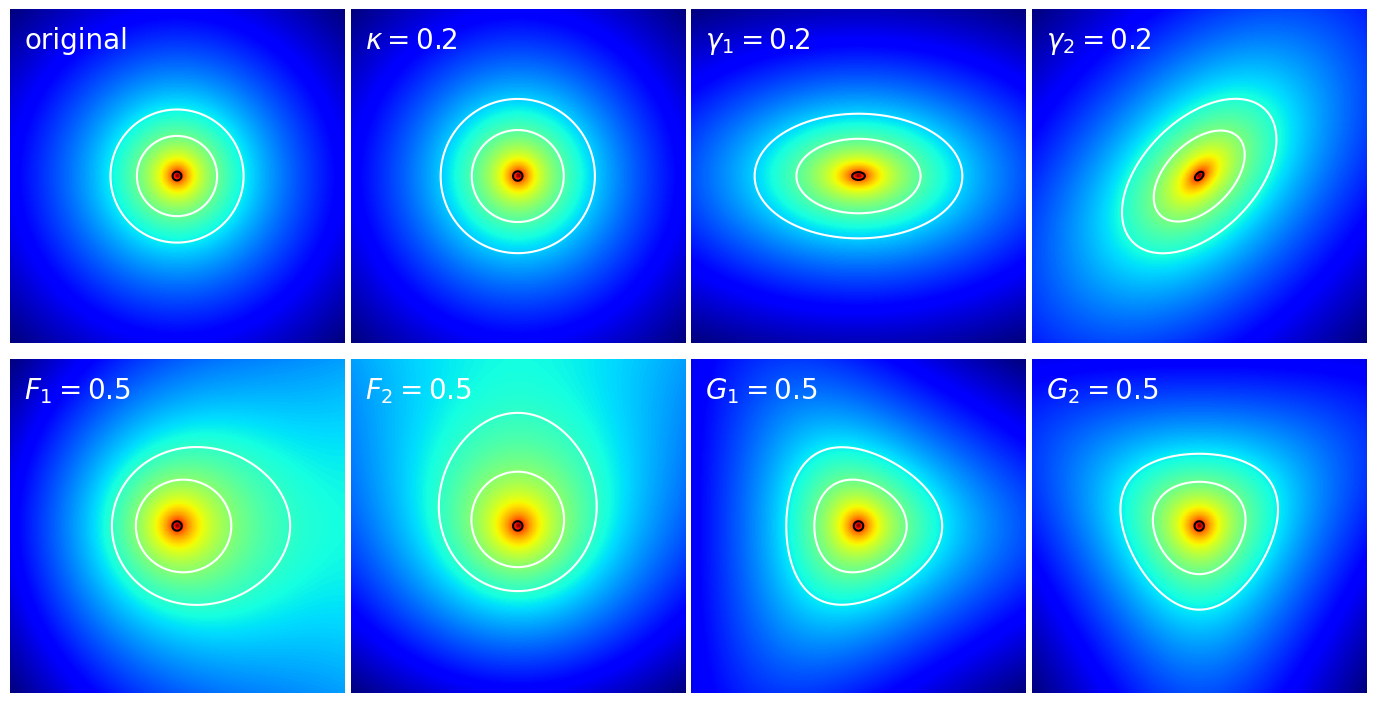

In [6]:
fig,ax=plt.subplots(2,4,figsize=(17.5,9))
se.lens(kappa=0.0, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,0].imshow(se.unlensed,origin='lower',norm=LogNorm())
ax[0,0].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,0].text(10,220,'original',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,1].text(10,220,'$\kappa=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.2, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,2].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,2].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,2].text(10,220,'$\gamma_1=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.2, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,3].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,3].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,3].text(10,220,'$\gamma_2=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.5,f2=0.0,g1=0.0,g2=0.0)
ax[1,0].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,0].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,0].text(10,220,'$F_1=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.5,g1=0.0,g2=0.0)
ax[1,1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,1].text(10,220,'$F_2=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.5,g2=0.0)
ax[1,2].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,2].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,2].text(10,220,'$G_1=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.5)
ax[1,3].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,3].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,3].text(10,220,'$G_2=0.5$',color='white',fontsize=20)

for i in range(2):
    for j in range(4):
        ax[i,j].axis('off')
        
        
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.savefig("flexion.png")